# Image segmentaion with masked facies

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import sys
from numbers import Integral
from random import uniform
from PIL import Image as pil_image
import fastai
from fastai.vision import *
from fastai.vision import Image
from fastai.vision.transform import _minus_epsilon
from fastai.vision.data import SegmentationProcessor
from mask_functions import *
from collections import defaultdict
import cv2
from IPython.display import display 

In [4]:
fastai.__version__

'1.0.60.dev0'

In [5]:
torch.cuda.set_device(0)

In [6]:
SUBSET_DATA=False
SUBSET_LEN=100

In [7]:
#training image size
TGT_HEIGHT_SMALL = 128
TGT_HEIGHT_MEDIUM = 256
TGT_HEIGHT_FULL = 512

In [44]:
data_dir = Path('../data')
train_images = data_dir/'train_images'
train_path = train_images/'cropped_512/train'
train_mask = train_path/'masks'
train_img = train_path/'images'

train_mask_128 = train_path/'masks_128'
train_mask_128.mkdir(exist_ok=True)
train_img_128 = train_path/'images_128'
train_img_128.mkdir(exist_ok=True)

train_mask_256 = train_path/'masks_256'
train_mask_256.mkdir(exist_ok=True)
train_img_256 = train_path/'images_256'
train_img_256.mkdir(exist_ok=True)

test_img = train_images/'cropped_512/test'
test_img_128 = train_images/'test_128'
test_img_128.mkdir(exist_ok=True)

In [19]:
filename = '../data/CAX_LogFacies_Train_File.csv'

#### all data

In [20]:
training_data = pd.read_csv(filename)
training_data.head()
training_data['well_file']='well_'+training_data['well_id'].astype(str)+'.png'
wells=training_data['well_file'].unique()
all_wells_df=pd.DataFrame(wells)
all_wells_df.head()
    
df_val = all_wells_df.sample(frac=0.2)
idx=df_val.index
df_trn=all_wells_df[~all_wells_df.index.isin(idx)]
assert len(df_val)+len(df_trn)==len(all_wells_df)
#df_val.to_csv(train_path/'val_20pct.csv', index=False, header=False)

In [21]:
df_val.head()

,0
3689,well_3689.png
2900,well_2900.png
3796,well_3796.png
3820,well_3820.png
1512,well_1512.png


### Data

In [22]:
train_img_names = get_image_files(train_img)
len(train_img_names)

32000

In [23]:
train_mask_names = get_image_files(train_mask)
len(train_mask_names)

32000

In [24]:
train_img_names[:3]

[PosixPath('../data/train_images/cropped_512/train/images/well_3666_crop_3.png'),
 PosixPath('../data/train_images/cropped_512/train/images/well_3886_crop_6.png'),
 PosixPath('../data/train_images/cropped_512/train/images/well_2037_crop_6.png')]

In [25]:
test_img

PosixPath('../data/train_images/cropped_512/train/test')

In [28]:
test_img_names= get_image_files(test_img)
len(test_img_names)

16000

#### Resize with opencv

In [29]:
def resize_cv(f, outpath, size):
    '''using open CV to resize as this allows exact dims to be used'''
    pil_im=pil_image.open(f)
    img=np.array(pil_im)
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    resized = cv2.resize(img, size, interpolation = cv2.INTER_LANCZOS4) 
    outimg = pil_image.fromarray(resized, "RGB" )
    out_file=outpath/f'{f.name}'
    outimg.save(out_file)
    outimg.close()

In [30]:
def resize_all_cv(size, fnames, mnames):
    pma=path_lbl/f'{size[0]}'
    os.makedirs(pma, exist_ok=True)
    pim=path_img/f'{size[0]}'
    os.makedirs(pim, exist_ok=True)
    for f in fnames:
        resize_cv(f, pim, size)
    for f in mnames:
        resize_cv(f, pma, size)

In [31]:
#resize_all_cv((tgt_height,tgt_height), fnames, lbl_names)

In [32]:
def resize_masks():
    img = img.resize((new_width, new_height), Image.ANTIALIAS)

In [33]:
#### Resize with PIL

In [46]:
def resize_pil(f, outpath, size):
    pil_im=pil_image.open(f)
    pil_im.thumbnail(size, pil_image.NEAREST)
    out_file=outpath/f'{f.name}'
    pil_im.save(out_file)
    pil_im.close()

In [47]:
def resize_all_pil(fnames, dest, size):
    for f in fnames:
        resize_pil(f, dest, size)


In [48]:
#NB dont want antialias so use Nearest (dont want new colours)
resize_all_pil(train_img_names, dest=train_img_128, size=(TGT_HEIGHT_SMALL,TGT_HEIGHT_SMALL))

In [49]:
resize_all_pil(train_mask_names, dest=train_mask_128, size=(TGT_HEIGHT_SMALL,TGT_HEIGHT_SMALL))

In [50]:
resize_all_pil(train_img_names, dest=train_img_256, size=(TGT_HEIGHT_MEDIUM,TGT_HEIGHT_MEDIUM))
resize_all_pil(train_mask_names, dest=train_mask_256, size=(TGT_HEIGHT_MEDIUM,TGT_HEIGHT_MEDIUM))

### Data QC

In [29]:
ims = [open_image(cropped_train_img/f'well_{i}_crop_5.png') for i in range(6)]
im_masks = [open_image(cropped_train_mask/f'well_{i}_crop_5.png') for i in range(6)]

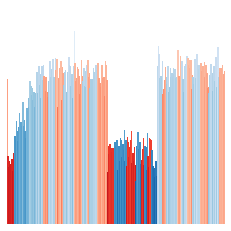

In [30]:
ims[0].show(figsize=(18,4))

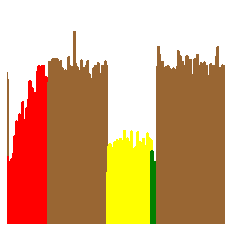

In [31]:
im_masks[0].show(figsize=(18,4))

In [32]:
imt = [open_image(cropped_test_img/f'well_{i}_crop_5.png') for i in range(5000, 5005)]
imt[0].show(figsize=(18,4))

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/ssd_1TB/Data/comps/crowdai/gamma_log_facies/train_images/cropped/mask_fill/test/cropped/well_5000_crop_5.png'